## Testing sequence reconstruction (varying L, delta) for Bidirectional beam search

Bidirectional beam search - https://github.com/GZHoffie/bbs

Varying L, delta for capping and no capping. Bernoulli trials for adding bases, failure - capping goes to the next strand, no capping continues with a deletion error. Running through Badread as the Nanopore error simulator

In [2]:
from synthesis import NaiveSynthesisModel
import numpy as np
from utils import create_fasta_file
from uuid import uuid4

In [8]:

coupling_rates = np.arange(0.9, 1.1, 0.01)
lengths = [50]
synthesis_models = []
repeats = 30
iterations = 5

for coupling_rate in coupling_rates:
    for length in lengths:
        for iteration in range(iterations):
            capped = NaiveSynthesisModel(coupling_rate=coupling_rate, strand_length=length, capping=False, repeats=repeats)
            synthesis_models.append(capped)



In [112]:
repeats_per_cr_length = [[] for i in range(10)]
lengths = np.arange(50, 210, 25)
coupling_rates = np.arange(0.9, 1.0, 0.01)

for i, coupling_rate in enumerate(coupling_rates):
    for length in lengths:
            repeats_per_cr_length[i].append(1/(coupling_rate)**length)

In [9]:
strands = []
references = []

for synth_model in synthesis_models:
    strands_ = synth_model.simulate_synthesis()
    if synth_model.capping:
        strands_ = [i for i in strands_ if len(strands_) == synth_model.strand_length]  # Filtering out incomplete capping strands
    strands.extend(strands_)
    references.append(synth_model.strand)

In [10]:
ids = [uuid4() for i in range(len(strands))]

In [11]:
len(strands)

3150

In [12]:
# Writing strands to fasta for badread

create_fasta_file(ids, strands, "bbs.fasta")

File saved as bbs.fasta


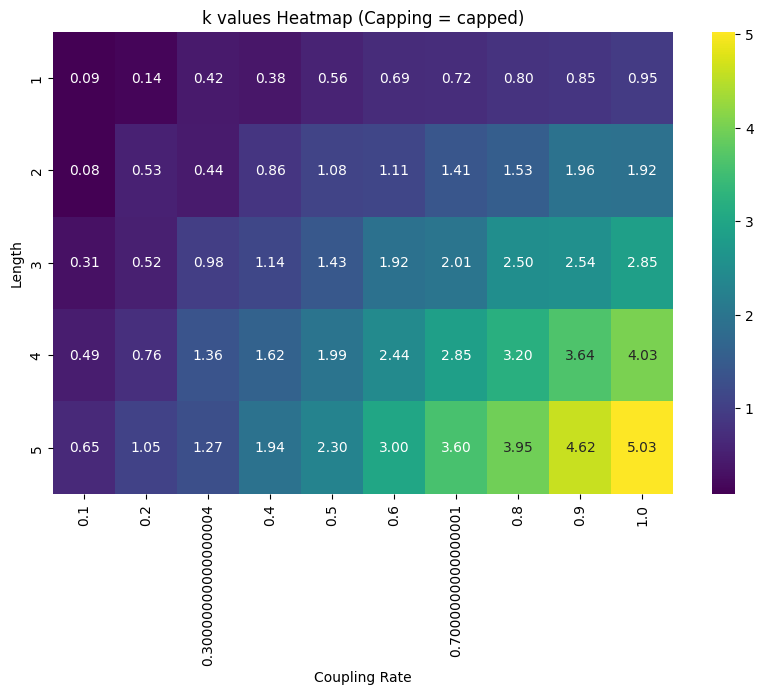

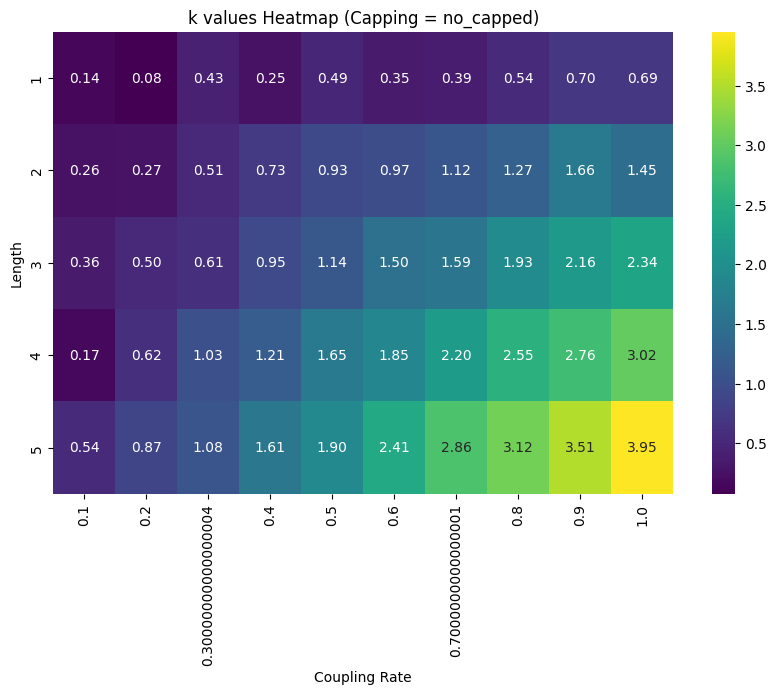

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample parameters
coupling_rates = np.linspace(0.1, 1.0, 10)  # 10 coupling rates
lengths = np.arange(1, 6)                   # 5 lengths
capping_conditions = ['capped', 'no_capped']

# Generate sample k values (random for illustration)
data = []
for capping in capping_conditions:
    for length in lengths:
        for rate in coupling_rates:
            # Example function: k depends on length, coupling rate, and capping
            base = length * rate * (1 if capping == 'capped' else 0.8)
            noise = np.random.normal(scale=0.1)
            k = base + noise
            data.append({'coupling_rate': rate, 'length': length, 'capping': capping, 'k': k})

df = pd.DataFrame(data)

# Plot heatmaps for each capping condition
for capping in capping_conditions:
    subset = df[df['capping'] == capping]
    pivot = subset.pivot(index='length', columns='coupling_rate', values='k')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='viridis')
    plt.title(f'k values Heatmap (Capping = {capping})')
    plt.xlabel('Coupling Rate')
    plt.ylabel('Length')
    plt.show()


In [17]:
!pip install plotly

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.6 MB 744.7 kB/s eta 0:00:13
   - -------------------------------------- 0.4/9.6 MB 2.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/9.6 MB 4.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/9.6 MB 4.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.6 MB 4.9 MB/s eta 0:00:02
   ----------- ---------------------------- 2.8/9.6 MB 7.8 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.6 MB 7.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.6 MB 7.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.6 MB 7.6 MB/s eta 0:00:01
   -------------- ------------------------- 3.6/9.6 MB 6.5 MB/s eta 0:00:01
   -------------------- -------

DEPRECATION: Loading egg at c:\users\parv\anaconda3\envs\pytorch_gpu\lib\site-packages\ont_bonito-0.8.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
import plotly.express as px
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Assuming df with 'coupling_rate', 'length', 'capping', 'k'

def plot_for_length(selected_length):
    filtered = df[df['length'] == selected_length]
    fig = px.line(
        filtered, 
        x='coupling_rate', 
        y='k', 
        color='capping', 
        markers=True,
        title=f'k vs Coupling Rate (Length={selected_length})'
    )
    fig.show()
    fig.write_html("interactive_plot.html")

# Dropdown widget for selecting length
lengths = sorted(df['length'].unique())
dropdown = widgets.Dropdown(options=lengths, description='Length:')

# Link widget and plotting function
widgets.interact(plot_for_length, selected_length=dropdown)


interactive(children=(Dropdown(description='Length:', options=(np.int64(1), np.int64(2), np.int64(3), np.int64…

<function __main__.plot_for_length(selected_length)>

In [19]:
fig.write_html("interactive_plot.html")

NameError: name 'fig' is not defined

### Coupling rate 0.9 - 1 (length 200) - no capping

1. Read fq
2. Cluster
3. Write for BBS
4. Check results

In [36]:
from utils import get_fastq_records

In [37]:
sequenced_strands = get_fastq_records(fastq_filepath=r"C:\Users\Parv\Doc\RA\Projects\clustering_dna_storage\reads.fastq\reads.fastq")

11553it [00:00, 22872.05it/s]


In [38]:
sequenced_strands_ = [str(i.seq) for i in sequenced_strands]

In [39]:
from clustering import Clustering

In [95]:
sequenced_50  = [i for i in sequenced_strands_ if len(i) <= 205 and len(i) > 195]

In [96]:
s = Clustering(sequenced_50, reference_length=150, distance_threshold=35)
s.cluster_strand_pool()

Total strands 1567


100%|██████████| 1567/1567 [00:00<00:00, 21757.61it/s]

Number of clusters = 14
Clusters are sorted
Orientation fixed in the strand pool


[['AAGATCCATCTGGCGGTGACCCCACCGGTAGCTTTCACCCTAGGGATATTTTCTAAAAGGATGTGGTAGAAAGGCGGACGAGTAGCCTAAGGTGCGAGGGCGATTCAACATATGGTATTATGATTTCTGCACGTTATTAACCGCCCGAAGTCAATGGCAAGCGCTGTGTCGATTGATTCGTCTGACACCTGGTTGGGCAT',
  'GAAAGATCCATCTGGCGGTGACCCCACCGTAGCTTTCACCCTAGGGATATTTTCTAAAGAGGATGTGGTAGAAAGGCGGACGAGTAGCCTAAGGTGCGAGGGCGATTCAACATATGGTATATGATTTCTGCACGTTATTAACCGCCCGAAGTCAATGGCAAGCGCTGTGTCGAATCCATTCGTCACACACCTGGTTGGGCAT',
  'AAAGATCCATCTGGCGGTGACCCCACCGTAGTTTTCACCCTAGGGATATTTTCTAAAAGGATGTGGTAGAAAGGCGGACGAGTAGCCTAAGGTGCGAGGGCGATTCAACATATGGTATTATGATTCTTGCACGTTATTAACCGCCCGAAGTCAATGGCAAGCGCTGTGTCGATTGATTCGTCAGACACCTGGTTGGGCAT',
  'AAAGATCCATCTGGCGGTGACCCCACCGTAGCTTTCACCCTAGGGATATTTTCTAAAAGGATGTGGTAGAAAGGCGGACGAGTAGCCTAAGGTGCGAGGGCGATTCAAATATGGTATTATGATTTCTGCACGTTATTAACGGTCTGAACTCAATGGCAAGCGCTGTGTCGGTCACTCTAGATTAGACACCTGGTTGGGCAT',
  'AAAGATCCATCTGGCGGTGACCCCACCGTAGCTTTCACCCTAGGGATATTTTCTAAAAGGATGTGGTAGAAAGGCGCACGGAGTAGCCTAAGGTGCGAGGGCGATTCAATAGTATGGTATTATGATTTCTGCACGTTATGAACCGCCGGAAGTTAATGGCAAGCGCTGTG

In [97]:
def write_clusters_for_bbs(clustered_seqs, output_filepath='clusters.txt'):

    with open(output_filepath, 'w') as f:
        for i in clustered_seqs:
            f.write('===============================\n')
            for j in i:
                f.write(j + "\n")


In [98]:
# Writing 10 repeats each, see how it does

clustered_seqs = [np.random.choice(i, 3) for i in s.clustered_seqs]

write_clusters_for_bbs(clustered_seqs, output_filepath=r"C:\Users\Parv\Doc\RA\Projects\negC\bbs\build\clusters.txt")


In [45]:
references = [i.strand for i in synthesis_models]

In [46]:
from Levenshtein import distance
from utils import reverse_complement

In [ ]:
# Save clusters

import json

dict_ = {f"cluster_{i}": s.clustered_seqs[i] for i in range(len(s.clustered_seqs))}

with open("bbs_clusters.json", "w") as f:
    json.dump(dict_, f)

In [99]:
import pandas as pd


df = pd.read_csv(r"C:\Users\Parv\Doc\RA\Projects\negC\bbs\build\output.csv")

reconstructed = df['reconstruction_result'].tolist()

indices = []
min_distances = []

for i in reconstructed:
    rev_i = reverse_complement(i)
    min_distance = 200
    index = 0
    for ptr, j in enumerate(references):

        dis1 = distance(i, j)
        dis2 = distance(rev_i, j)

        if dis1 < min_distance:
            index = ptr
            min_distance = dis1
        
        
        if dis2 < min_distance:
            index = ptr
            min_distance = dis2

    indices.append(index)
    min_distances.append(min_distance)


for ptr, indice in enumerate(indices):
    min_distance = min_distances[ptr]
    reference_cr = synthesis_models[indice].coupling_rate
    L = synthesis_models[indice].strand_length

    print(f"Minimum distance {min_distance}, Coupling rate {reference_cr}, L {L}")

Minimum distance 0, Coupling rate 1.0, L 200
Minimum distance 0, Coupling rate 1.0, L 200
Minimum distance 0, Coupling rate 1.0, L 200
Minimum distance 0, Coupling rate 1.0, L 200
Minimum distance 2, Coupling rate 1.0, L 200
Minimum distance 98, Coupling rate 1.0, L 100
Minimum distance 79, Coupling rate 1.0, L 125
Minimum distance 54, Coupling rate 1.0, L 150
Minimum distance 75, Coupling rate 1.0, L 125
Minimum distance 48, Coupling rate 1.0, L 150
Minimum distance 55, Coupling rate 1.0, L 150
Minimum distance 71, Coupling rate 1.0, L 125
Minimum distance 98, Coupling rate 1.0, L 150
Minimum distance 53, Coupling rate 1.0, L 150


In [ ]:
k_50 = [3, 3, 4, ]

In [119]:
k = [4, 4, 5, 6, 9, 10, 10, 15, 20, 24]
del_rate = np.arange(0.01, 0.11, 0.01)


Text(0, 0.5, 'Number of strands')

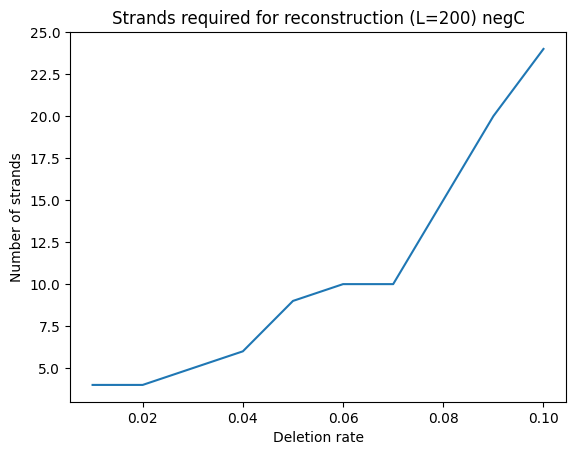

In [121]:
import matplotlib.pyplot as plt

plt.plot(del_rate, k)
plt.title("Strands required for reconstruction (L=200) negC")
plt.xlabel("Deletion rate")
plt.ylabel("Number of strands")

So a bash script that takes the clusters.txt, and for each, until it matches it increases by 1?
But that's way too slow right? Not for the 50 at least
I think that should be fine for no capping
It also needs to track the ones to not increase. 
This is a pain